In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch.utils.data import Dataset
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
dataset_paths = []
records_folder = "../data/record"
for name in os.listdir(records_folder):
   dir = os.path.join(records_folder, name)
   if os.path.isdir(dir):
      dataset_paths.append(dir)

print(dataset_paths)

actions = [
    "Void",
    "Left",
    "Right",
    "Straight",
    "LaneFollow",
    "ChangeLaneLeft",
    "ChangeLaneRight",
    "RoadEnd",
    "Other",
]
actions_index_map = {a: i for i, a in enumerate(actions)}

['../data/record\\Town01_100npcs_1', '../data/record\\Town01_200npcs_1', '../data/record\\Town04_100npcs_1', '../data/record\\Town05_100npcs_1', '../data/record\\Town05_100npcs_2', '../data/record\\Town07_100npcs_1', '../data/record\\Town07_100npcs_2', '../data/record\\Town12_1200npcs_1', '../data/record\\Town12_1200npcs_2', '../data/record\\Town12_1200npcs_3', '../data/record\\Town12_800npcs_1']


In [3]:
class BehaviorPredictionDataset(Dataset):
    def __init__(self, dataset_paths, return_metadata=False, transform=None, sensor_range=50.0, bev_range=50.0):
        super().__init__()
        self.records = []
        self.return_metadata = return_metadata
        self.transform = transform
        self.sensor_range = sensor_range
        self.bev_range = bev_range

        for path in dataset_paths:
            self.read_data_folder(path)
    
    def read_data_folder(self, path):
        for agent in os.listdir(os.path.join(path, 'agents')):
            agent_folder = os.path.join(path, 'agents', agent)

            agent_location = {}
            for line in open(os.path.join(agent_folder, 'gt_location', 'data.jsonl'), 'r'):
                record = json.loads(line)
                agent_location[record['frame']] = {
                    'location': record['location'],
                    'rotation': record['rotation'],
                }

            vehicle_bbox_records = []
            
            for line in open(os.path.join(agent_folder, 'gt_vehicle_bbox', 'data.jsonl'), 'r'):
                record = json.loads(line)
                vehicle_bbox_records.append(record)
                frame = record['frame']
                for vehicle in record['vehicles']:
                    distance = np.linalg.norm(np.array(agent_location[frame]['location'])-np.array(vehicle['location']))
                    if distance > self.sensor_range:
                        continue
                    self.records.append({
                        'vehicle_id': vehicle['id'],
                        'frame': frame,
                        'timestamp': record['timestamp'],
                        'current_action': vehicle['current_action'],
                        'distance': distance,
                        'agent_location': np.array(agent_location[frame]['location']),
                        'agent_rotation': np.array(agent_location[frame]['rotation']),
                        'vehicle_location': np.array(vehicle['location']),
                        'vehicle_rotation': np.array(vehicle['rotation']),
                        'bev_image_path': os.path.join(agent_folder, 'birds_view_semantic_camera', str(frame)+'.png'),
                        'output_path': os.path.join(agent_folder, 'pred_vehicle_current_action', 'data.jsonl'),
                    })
    
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, index):
        record = self.records[index]
        agent_image = cv2.imread(record['bev_image_path'])
        agent_image = cv2.cvtColor(agent_image, cv2.COLOR_BGR2RGB)
        y = actions_index_map[record['current_action']]
        width = agent_image.shape[1]
        height = agent_image.shape[0]
        assert agent_image.shape[0] == agent_image.shape[1]
        img_scale =  agent_image.shape[0] / (self.bev_range*2)
        
        image = agent_image
        # Rotate the image to standard rotation
        agent_pitch = record['agent_rotation'][2]
        # print(agent_pitch)
        mat = cv2.getRotationMatrix2D((width/2, height/2), -agent_pitch, 1.0)
        image = cv2.warpAffine(src=agent_image, M=mat, dsize=(width, height))

        translation = record['vehicle_location'] - record['agent_location']
        # Move the vehicle to the center
        translation_matrix = np.array([
            [1, 0, -translation[1]*img_scale],
            [0, 1, translation[0]*img_scale]
        ], dtype=np.float32)

        image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height))
        
        # print(translation[0], translation[1])
        # print(translation[0]*img_scale, translation[1]*img_scale)

        vehicle_pitch = record['vehicle_rotation'][2]
        # print(vehicle_pitch)
        mat = cv2.getRotationMatrix2D((width/2, height/2), vehicle_pitch, 1.0)
        image = cv2.warpAffine(src=image, M=mat, dsize=(width, height))

        # print(record['vehicle_id'])

        if self.transform is not None:
            image = self.transform(image)

        if self.return_metadata:
            return image, y, self.records[index]
        return image, y

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = BehaviorPredictionDataset(dataset_paths, transform=preprocess)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(train_size, test_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(233))

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
)


46653 11664


58317


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


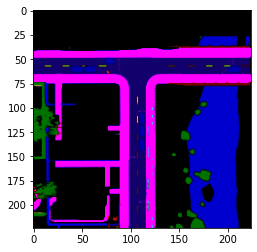

In [4]:
print(len(dataset))
img, label = dataset[212]
plt.imshow(np.array(img).transpose(1, 2, 0))
print(label)

In [5]:
from torch import nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

class BehaviorPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
        self.linear = nn.Linear(1000, len(actions))

    def forward(self, x):
        x = self.backbone(x)
        x = self.linear(x)
        return x

model = BehaviorPredictionModel()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

save_dir = '../tmp/BehaviorPrediction/'
os.makedirs(save_dir, exist_ok=True)


cuda:0


Using cache found in C:\Users\IX/.cache\torch\hub\pytorch_vision_v0.10.0
d:\Workspace\Autopilot\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Workspace\Autopilot\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
try:
    model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth')))
    optimizer.load_state_dict(torch.load(os.path.join(save_dir, 'optimizer.pth')))
except Exception as e:
    print(e)

In [7]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0.0
    for i, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)

        with torch.no_grad():
            _, predictions = torch.max(y_pred, 1)
            train_correct = train_correct + (predictions == y).float().sum()

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / len(train_dataset)
    print(f'Epoch {epoch} training loss: {train_loss} accuracy: {train_acc}')

    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0.0
        for i, data in enumerate(test_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            _, predictions = torch.max(y_pred, 1)
            test_correct = test_correct + (predictions == y).float().sum()
            test_loss += loss.item()
        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / len(test_dataset)
        print(f'Epoch {epoch} testing loss: {test_loss} accuracy: {test_acc}')


Epoch 0 training loss: 1.1275527605733262 accuracy: 0.7796068787574768
Epoch 0 testing loss: 0.26713911456162814 accuracy: 0.9148662686347961
Epoch 1 training loss: 0.19734056659083715 accuracy: 0.9360598921775818
Epoch 1 testing loss: 0.17803489180699072 accuracy: 0.9439300298690796
Epoch 2 training loss: 0.13539895854139156 accuracy: 0.9568945169448853
Epoch 2 testing loss: 0.13783496369918188 accuracy: 0.9553326368331909
Epoch 3 training loss: 0.10317823439178572 accuracy: 0.9662401080131531
Epoch 3 testing loss: 0.13175108337194705 accuracy: 0.9619341492652893
Epoch 4 training loss: 0.09654968286850407 accuracy: 0.9685765504837036
Epoch 4 testing loss: 0.11733692055160963 accuracy: 0.966906726360321
Epoch 5 training loss: 0.06958486934975608 accuracy: 0.9768932461738586
Epoch 5 testing loss: 0.14087544557704626 accuracy: 0.9603052139282227
Epoch 6 training loss: 0.06030145941172191 accuracy: 0.9801942110061646
Epoch 6 testing loss: 0.10435182989010068 accuracy: 0.9703360795974731
E

In [8]:
torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'optimizer.pth'))


In [9]:
def write_pred():
    dataset = BehaviorPredictionDataset(dataset_paths, return_metadata=True, transform=preprocess)
    dataloader = DataLoader(
        dataset,
        batch_size=8,
        shuffle=False,
    )

    save_objs = {}

    total_loss = 0.0
    total_samples = 0.0
    total_correct = 0.0
    for i, data in enumerate(dataloader):
        x, y, meta = data
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)

        with torch.no_grad():
            _, predictions = torch.max(y_pred, 1)
            total_samples += y.shape[0]
            total_correct += (predictions == y).float().sum()

        for i in range(y.shape[0]):
            output_path = meta['output_path'][i]
            if output_path not in save_objs:
                save_objs[output_path] = {}
            frame = int(meta['frame'][i])
            if frame not in save_objs[output_path]:
                save_objs[output_path][frame] = {}
            save_objs[output_path][frame][meta['vehicle_id'][i]] = {
                'id': meta['vehicle_id'][i],
                'frame': int(meta['frame'][i]),
                'timestamp': float(meta['timestamp'][i]),
                'location': meta['vehicle_location'][i].tolist(),
                'rotation': meta['vehicle_rotation'][i].tolist(),
                'current_action': actions[predictions[i]],
                'current_action_gt': meta['current_action'][i],
            }

        total_loss += loss.item()
    total_loss = total_loss / len(dataloader)
    total_acc = total_correct / total_samples
    print(f'Average loss: {total_loss} accuracy: {total_acc}')

    for filepath, frames in save_objs.items():
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with open(filepath, 'w') as file:
            for frame in sorted(list(frames.keys())):
                line = json.dumps(save_objs[filepath][frame])
                file.write(line+"\n")

write_pred()

Average loss: 1.2253678088221702 accuracy: 0.838726282119751
